# Imports e Upload

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from datetime import datetime
import xgboost as xgb
import lightgbm as lgb

In [ ]:
df = pd.read_csv("../data/raw/dataset_carros_brasil.csv")

# Análise Exploratória

In [3]:
df.shape

(10000, 9)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Marca          10000 non-null  object 
 1   Modelo         10000 non-null  object 
 2   Ano            9900 non-null   float64
 3   Quilometragem  10000 non-null  object 
 4   Cor            10000 non-null  object 
 5   Cambio         10000 non-null  object 
 6   Combustivel    10000 non-null  object 
 7   Portas         10000 non-null  int64  
 8   Valor_Venda    10000 non-null  float64
dtypes: float64(2), int64(1), object(6)
memory usage: 703.3+ KB


In [5]:
display(df)

,Marca,Modelo,Ano,Quilometragem,Cor,Cambio,Combustivel,Portas,Valor_Venda
0,Ford,EcoSport,2003.0,82624,Azul,Automático,Flex,4,52604.2
1,Hyundai,HB20S,2017.0,69260,Azul,Automático,Diesel,2,63219.0
2,Jeep,Renegade,2008.0,106493,Cinza,Manual,Gasolina,2,79710.4
3,Toyota,Corolla,2018.0,53570,Prata,Automático,Flex,2,99149.0
4,Ford,Ranger,2009.0,21643,Prata,Manual,Flex,2,68913.4
...,...,...,...,...,...,...,...,...,...
9995,Ford,EcoSport,2008.0,141618,Vermelho,Automático,Flex,2,47848.4
9996,Nissan,Frontier,2019.0,141820,Branco,Manual,Gasolina,2,69586.0
9997,Fiat,Cronos,2003.0,67089,Vermelho,Manual,Flex,4,36726.2
9998,Nissan,Versa,2000.0,191101,Cinza,Manual,Flex,2,31730.8


## Removendo nulos

In [6]:
# Remover linhas com qualquer valor nulo
df_clean = df.dropna()

print("Shape original:", df.shape)
print("Shape após remoção de nulos:", df_clean.shape)

# Conferir se ainda restaram valores nulos
print("\nValores nulos por coluna:")
print(df_clean.isna().sum())

Shape original: (10000, 9)
Shape após remoção de nulos: (9900, 9)

Valores nulos por coluna:
Marca            0
Modelo           0
Ano              0
Quilometragem    0
Cor              0
Cambio           0
Combustivel      0
Portas           0
Valor_Venda      0
dtype: int64


In [7]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9900 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Marca          9900 non-null   object 
 1   Modelo         9900 non-null   object 
 2   Ano            9900 non-null   float64
 3   Quilometragem  9900 non-null   object 
 4   Cor            9900 non-null   object 
 5   Cambio         9900 non-null   object 
 6   Combustivel    9900 non-null   object 
 7   Portas         9900 non-null   int64  
 8   Valor_Venda    9900 non-null   float64
dtypes: float64(2), int64(1), object(6)
memory usage: 773.4+ KB


## Verificando as colunas categóricas

In [8]:
categorical_cols = ["Marca", "Modelo", "Cor", "Cambio", "Combustivel", "Portas", "Quilometragem"]

for col in categorical_cols:
    uniques = df_clean[col].unique()
    print(f"\n{col}")
    print(f"Total de categorias: {len(uniques)}")
    print(uniques)


Marca
Total de categorias: 10
['Ford' 'Hyundai' 'Jeep' 'Toyota' 'Nissan' 'Fiat' 'Honda' 'Chevrolet'
 'Volkswagen' 'Renault']

Modelo
Total de categorias: 32
['EcoSport' 'HB20S' 'Renegade' 'Corolla' 'Ranger' 'Frontier' 'Toro'
 'Hilux' 'HB20' 'Argo' 'Civic' 'Onix Plus' 'HR-V' 'Gol' 'Kicks' 'Sandero'
 'Virtus' 'Versa' 'Yaris' 'Mobi' 'Ka' 'Kwid' 'Tracker' 'Creta' 'Cronos'
 'T-Cross' 'Compass' 'S10' 'Duster' 'Onix' 'Polo' 'Fit']

Cor
Total de categorias: 6
['Azul' 'Cinza' 'Prata' 'Preto' 'Vermelho' 'Branco']

Cambio
Total de categorias: 2
['Automático' 'Manual']

Combustivel
Total de categorias: 3
['Flex' 'Diesel' 'Gasolina']

Portas
Total de categorias: 2
[4 2]

Quilometragem
Total de categorias: 9559
['82624' '69260' '106493' ... '67089' '191101' '156313']


## Limpando a Quilometragem

In [9]:
# Contagem dos valores únicos
print(df_clean["Quilometragem"].value_counts().head(20))
print("\nTotal de valores distintos:", df_clean["Quilometragem"].nunique())

# Mostrar exemplos que não são numéricos
mask_non_numeric = df_clean["Quilometragem"].str.contains(r"[^\d\.]", regex=True, na=False)
print("\nExemplos de valores com texto dentro:")
print(df_clean.loc[mask_non_numeric, "Quilometragem"].unique()[:20])

Quilometragem
erro_medicao    99
124790           3
97491            3
166373           3
118222           3
116465           2
14546            2
61402            2
177734           2
150025           2
108407           2
175765           2
26974            2
58852            2
76981            2
57564            2
143603           2
63884            2
78776            2
65059            2
Name: count, dtype: int64

Total de valores distintos: 9559

Exemplos de valores com texto dentro:
['erro_medicao']


In [10]:
df_clean = df_clean[df_clean["Quilometragem"] != "erro_medicao"].copy()
print("Shape após remoção:", df_clean.shape)

Shape após remoção: (9801, 9)


In [11]:
df_clean.describe()

,Ano,Portas,Valor_Venda
count,9801.000000,9801.000000,9.801000e+03
mean,2011.509438,3.009693,8.320082e+04
std,6.897880,1.000004,1.672646e+05
min,2000.000000,2.000000,1.000000e+04
25%,2006.000000,2.000000,4.444760e+04
50%,2012.000000,4.000000,5.893580e+04
75%,2017.000000,4.000000,7.484280e+04
max,2023.000000,4.000000,1.241962e+06


## Arrumando os tipos

In [12]:
df_clean["Ano"] = df_clean["Ano"].astype(int)
df_clean["Quilometragem"] = df_clean["Quilometragem"].astype(float)
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9801 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Marca          9801 non-null   object 
 1   Modelo         9801 non-null   object 
 2   Ano            9801 non-null   int64  
 3   Quilometragem  9801 non-null   float64
 4   Cor            9801 non-null   object 
 5   Cambio         9801 non-null   object 
 6   Combustivel    9801 non-null   object 
 7   Portas         9801 non-null   int64  
 8   Valor_Venda    9801 non-null   float64
dtypes: float64(2), int64(2), object(5)
memory usage: 765.7+ KB


## Verificando Outliers (Ainda não apaguei)

In [13]:
# Função para contar outliers com base no IQR
def contar_outliers(grupo, coluna="Valor_Venda"):
    Q1 = grupo[coluna].quantile(0.25)
    Q3 = grupo[coluna].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    outliers = grupo[(grupo[coluna] < limite_inferior) | (grupo[coluna] > limite_superior)]
    return len(outliers)

# Calcular outliers por marca
outliers_por_marca = df_clean.groupby("Marca").apply(contar_outliers).reset_index(name="Qtd_Outliers")

# Ordenar do maior para o menor
outliers_por_marca = outliers_por_marca.sort_values(by="Qtd_Outliers", ascending=False)

outliers_por_marca.head(50)

/tmp/ipython-input-1224703819.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  outliers_por_marca = df_clean.groupby("Marca").apply(contar_outliers).reset_index(name="Qtd_Outliers")


,Marca,Qtd_Outliers
1,Fiat,28
0,Chevrolet,24
6,Nissan,24
7,Renault,23
9,Volkswagen,20
2,Ford,17
8,Toyota,17
4,Hyundai,16
5,Jeep,15
3,Honda,14


In [14]:
# Calcular outliers por modelo
outliers_por_modelo = df_clean.groupby("Modelo").apply(contar_outliers).reset_index(name="Qtd_Outliers")

# Ordenar do maior para o menor
outliers_por_modelo = outliers_por_modelo.sort_values(by="Qtd_Outliers", ascending=False)

outliers_por_modelo.head(50)

/tmp/ipython-input-2748338716.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  outliers_por_modelo = df_clean.groupby("Modelo").apply(contar_outliers).reset_index(name="Qtd_Outliers")


,Modelo,Qtd_Outliers
5,Cronos,12
9,Frontier,12
23,Renegade,10
17,Kwid,10
18,Mobi,9
19,Onix,8
15,Ka,8
20,Onix Plus,8
24,S10,7
31,Yaris,7


<Figure size 1200x600 with 0 Axes>

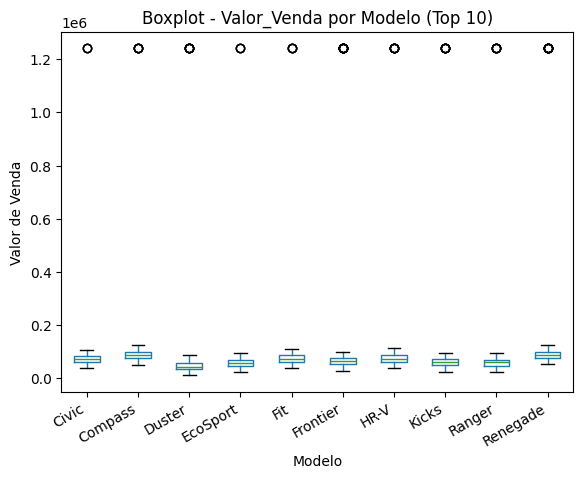

In [15]:
# Selecionar os 10 modelos mais frequentes
top_modelos = df_clean["Modelo"].value_counts().head(10).index
df_clean_top = df_clean[df_clean["Modelo"].isin(top_modelos)]

plt.figure(figsize=(12,6))
df_clean_top.boxplot(column="Valor_Venda", by="Modelo", showfliers=True, grid=False)
plt.title("Boxplot - Valor_Venda por Modelo (Top 10)")
plt.suptitle("")
plt.xlabel("Modelo")
plt.ylabel("Valor de Venda")
plt.xticks(rotation=30, ha="right")
plt.show()


# Removendo outliers por marca

In [16]:
df_clean = df.dropna()
df_clean = df_clean[df_clean["Quilometragem"] != "erro_medicao"].copy()
df_clean["Ano"] = df_clean["Ano"].astype(int)
df_clean["Quilometragem"] = df_clean["Quilometragem"].astype(float)


# Função que calcula os limites IQR e filtra o grupo
def remover_outliers_grupo(grupo, coluna='Valor_Venda'):
    Q1 = grupo[coluna].quantile(0.25)
    Q3 = grupo[coluna].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR

    # Retorna o grupo filtrado, mantendo apenas os valores dentro dos limites
    return grupo[(grupo[coluna] >= limite_inferior) & (grupo[coluna] <= limite_superior)]

# Agrupar o DataFrame por 'Marca'
# Aplicar a função a cada grupo
# Resetar o índice para juntar os grupos de volta em um único DataFrame
print(f"Shape antes da remoção de outliers por marca: {df_clean.shape}")

df_clean = df_clean.groupby('Marca').apply(remover_outliers_grupo).reset_index(drop=True)

print(f"Shape depois da remoção de outliers por marca: {df_clean.shape}")

df_clean.groupby('Marca')['Valor_Venda'].describe()

Shape antes da remoção de outliers por marca: (9801, 9)
Shape depois da remoção de outliers por marca: (9603, 9)


/tmp/ipython-input-3938532033.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_clean = df_clean.groupby('Marca').apply(remover_outliers_grupo).reset_index(drop=True)


,count,mean,std,min,25%,50%,75%,max
Marca,,,,,,,,
Chevrolet,948.0,48945.603797,16163.088247,10000.0,37261.15,48889.7,60768.65,88726.4
Fiat,947.0,45505.569588,15696.905728,10000.0,34254.30,45283.2,56588.20,84047.6
Ford,983.0,57247.147508,16012.054296,19524.2,45465.90,57526.6,69105.20,94471.6
Honda,989.0,72237.992315,16189.960476,36135.2,60135.40,72560.6,84195.00,111464.0
Hyundai,924.0,52751.791558,14525.435808,16951.0,43133.85,52743.0,62807.20,91396.2
Jeep,938.0,87053.177825,15832.594182,48862.6,75777.25,86984.6,97842.45,124196.2
Nissan,994.0,62089.731992,15931.669156,21502.6,50250.65,62408.8,73763.10,104107.6
Renault,949.0,44502.650580,15731.629170,10000.0,33453.20,43749.8,56012.80,85909.6
Toyota,920.0,76858.490217,15876.194927,36034.6,65603.20,76636.3,88092.75,118311.4


# Verificando duplicatas

In [17]:
print(f"Linhas duplicadas: {df_clean.duplicated().sum()}")
df_clean.drop_duplicates(inplace=True)

Linhas duplicadas: 0


# Criando features

In [18]:
from datetime import datetime

ano_atual = datetime.now().year
df_clean['Idade_Veiculo'] = ano_atual - df_clean['Ano']

df_clean.drop('Ano', axis=1, inplace=True)

In [19]:
# Adicionamos +1 na idade para evitar divisão por zero caso o carro seja do ano corrente
df_clean['Km_por_Ano'] = df_clean['Quilometragem'] / (df_clean['Idade_Veiculo'] + 1)

In [20]:
df_modelo = df_clean.copy()

df_modelo = pd.get_dummies(df_modelo, columns=['Marca', 'Modelo', 'Cor', 'Cambio', 'Combustivel'], drop_first=True)
X = df_modelo.drop('Valor_Venda', axis=1)
y = df_modelo['Valor_Venda']

# Divisão em Treino e Teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Dicionário com os modelos que vamos treinar
modelos = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42, n_jobs=-1), # n_jobs=-1 usa todos os processadores
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "XGBoost": xgb.XGBRegressor(random_state=42, n_jobs=-1),
    "LightGBM": lgb.LGBMRegressor(random_state=42, n_jobs=-1)
}

# Lista para armazenar os resultados
resultados = []

# Loop para treinar e avaliar cada modelo
print("Iniciando treinamento e avaliação dos modelos...")
for nome, modelo in modelos.items():
    print(f"Treinando {nome}...")
    # Treinar o modelo
    modelo.fit(X_train, y_train)

    # Fazer previsões
    previsoes = modelo.predict(X_test)

    # Calcular as métricas
    mae = mean_absolute_error(y_test, previsoes)
    rmse = np.sqrt(mean_squared_error(y_test, previsoes))
    r2 = r2_score(y_test, previsoes)

    # Adicionar os resultados à lista
    resultados.append({
        "Modelo": nome,
        "MAE (R$)": mae,
        "RMSE (R$)": rmse,
        "R²": r2
    })

# Avaliação e Comparação
df_resultados = pd.DataFrame(resultados).sort_values(by='R²', ascending=False)

print("\nResultados Finais da Comparação dos Modelos")
print(df_resultados.round(4))

Iniciando treinamento e avaliação dos modelos...
Treinando Linear Regression...
Treinando Ridge Regression...
Treinando Lasso Regression...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.839e+08, tolerance: 3.402e+08
  model = cd_fast.enet_coordinate_descent(


Treinando Decision Tree...
Treinando Random Forest...
Treinando Gradient Boosting...
Treinando XGBoost...
Treinando LightGBM...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000244 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 634
[LightGBM] [Info] Number of data points in the train set: 7682, number of used features: 52
[LightGBM] [Info] Start training from score 59439.326550

Resultados Finais da Comparação dos Modelos
              Modelo   MAE (R$)  RMSE (R$)      R²
2   Lasso Regression  2527.4564  2917.8031  0.9803
0  Linear Regression  2528.4533  2919.5109  0.9803
1   Ridge Regression  2528.6220  2919.7418  0.9803
7           LightGBM  2599.5605  3083.2604  0.9780
5  Gradient Boosting  2714.0261  3234.9720  0.9758
4      Random Forest  2775.8137  

# Teste hiperparametrizando

In [21]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd
from datetime import datetime
import warnings
import xgboost as xgb
import lightgbm as lgb

# Ignorar avisos para manter a saída limpa
warnings.filterwarnings('ignore')

df_modelo = df_clean.copy()

df_modelo = pd.get_dummies(df_modelo, columns=['Marca', 'Modelo', 'Cor', 'Cambio', 'Combustivel'], drop_first=True)
X = df_modelo.drop('Valor_Venda', axis=1)
y = df_modelo['Valor_Venda']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Dicionário de modelos
modelos = {
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "Random Forest": RandomForestRegressor(random_state=42, n_jobs=-1),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "XGBoost": xgb.XGBRegressor(random_state=42, n_jobs=-1),
    "LightGBM": lgb.LGBMRegressor(random_state=42, n_jobs=-1)
}

# Grades de parâmetros para cada modelo
param_grids = {
    "Ridge": {
        'alpha': [0.1, 1.0, 10.0, 100.0]
    },
    "Lasso": {
        'alpha': [0.1, 1.0, 10.0, 100.0]
    },
    "Random Forest": {
        'n_estimators': [100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5]
    },
    "Gradient Boosting": {
        'n_estimators': [100, 200],
        'learning_rate': [0.05, 0.1],
        'max_depth': [3, 5]
    },
    "XGBoost": {
        'n_estimators': [100, 200],
        'learning_rate': [0.05, 0.1],
        'max_depth': [3, 5]
    },
    "LightGBM": {
        'n_estimators': [100, 200],
        'learning_rate': [0.05, 0.1],
        'num_leaves': [31, 40]
    }
}

# Loop de Treinamento com GridSearchCV
resultados_otimizados = []

print("Iniciando busca de hiperparâmetros com GridSearchCV...")
for nome, modelo in modelos.items():
    print(f"Otimizando {nome}...")

    grid_search = GridSearchCV(modelo, param_grids[nome], cv=5, scoring='r2', n_jobs=-1)

    # Treina o GridSearch
    grid_search.fit(X_train, y_train)

    # O melhor modelo encontrado pelo GridSearch
    melhor_modelo = grid_search.best_estimator_

    # Faz previsões com o melhor modelo
    previsoes = melhor_modelo.predict(X_test)

    # Avalia o melhor modelo
    mae = mean_absolute_error(y_test, previsoes)
    rmse = np.sqrt(mean_squared_error(y_test, previsoes))
    r2 = r2_score(y_test, previsoes)

    resultados_otimizados.append({
        "Modelo": nome,
        "MAE (R$)": mae,
        "RMSE (R$)": rmse,
        "R²": r2,
        "Melhores Parâmetros": grid_search.best_params_
    })

# Comparação dos Resultados Otimizados
df_resultados_otimizados = pd.DataFrame(resultados_otimizados).sort_values(by='R²', ascending=False)

print("\nResultados Finais dos Modelos Otimizados")
pd.set_option('display.max_colwidth', None)
df_resultados_otimizados.round(4)

Iniciando busca de hiperparâmetros com GridSearchCV...
Otimizando Ridge...
Otimizando Lasso...
Otimizando Random Forest...
Otimizando Gradient Boosting...
Otimizando XGBoost...
Otimizando LightGBM...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001073 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 634
[LightGBM] [Info] Number of data points in the train set: 7682, number of used features: 52
[LightGBM] [Info] Start training from score 59439.326550

Resultados Finais dos Modelos Otimizados


,Modelo,MAE (R$),RMSE (R$),R²,Melhores Parâmetros
1,Lasso,2527.4564,2917.8031,0.9803,{'alpha': 1.0}
0,Ridge,2528.6220,2919.7418,0.9803,{'alpha': 1.0}
4,XGBoost,2600.4039,3058.3697,0.9784,"{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}"
3,Gradient Boosting,2609.8190,3063.9909,0.9783,"{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}"
5,LightGBM,2611.7957,3085.4706,0.9780,"{'learning_rate': 0.05, 'n_estimators': 200, 'num_leaves': 31}"
2,Random Forest,2746.9229,3293.2949,0.9749,"{'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}"


In [22]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd
from datetime import datetime
import warnings
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')
sns.set(style='whitegrid')

df_modelo = df_clean.copy()

df_modelo = pd.get_dummies(df_modelo, columns=['Marca', 'Modelo', 'Cor', 'Cambio', 'Combustivel'], drop_first=True)
X = df_modelo.drop('Valor_Venda', axis=1)
y = df_modelo['Valor_Venda']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelos e Grades de Parâmetros
modelos = {
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "Random Forest": RandomForestRegressor(random_state=42, n_jobs=-1),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "XGBoost": xgb.XGBRegressor(random_state=42, n_jobs=-1),
    "LightGBM": lgb.LGBMRegressor(random_state=42, n_jobs=-1)
}
param_grids = {
    "Ridge": {'alpha': [0.1, 1.0, 10.0]},
    "Lasso": {'alpha': [0.1, 1.0, 10.0]},
    "Random Forest": {'n_estimators': [100, 200], 'max_depth': [10, 20]},
    "Gradient Boosting": {'n_estimators': [100, 200], 'learning_rate': [0.1], 'max_depth': [3]},
    "XGBoost": {'n_estimators': [100, 200], 'learning_rate': [0.1], 'max_depth': [3]},
    "LightGBM": {'n_estimators': [100, 200], 'learning_rate': [0.1], 'num_leaves': [31]}
}

# Loop de Treinamento, Avaliação e PLOTAGEM
print("Iniciando busca de hiperparâmetros e geração de gráficos...")
for nome, modelo in modelos.items():
    print(f"Otimizando e analisando {nome}...")

    grid_search = GridSearchCV(modelo, param_grids[nome], cv=3, scoring='r2', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    melhor_modelo = grid_search.best_estimator_

    # Extração e Plotagem da Importância das Features

    # Verificar se o modelo tem 'feature_importances_' (modelos de árvore) ou 'coef_' (modelos lineares)
    if hasattr(melhor_modelo, 'feature_importances_'):
        importances = melhor_modelo.feature_importances_
    elif hasattr(melhor_modelo, 'coef_'):
        importances = np.abs(melhor_modelo.coef_)
    else:
        continue # Pula para o próximo modelo se não tiver como medir a importância

    # Criar um DataFrame de features e suas importâncias
    feature_importance_df = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    # Pegar as 20 features mais importantes para o gráfico
    top_20_features = feature_importance_df.head(20)

    # Criar o gráfico
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=top_20_features, palette='viridis')
    plt.title(f'Top 20 Features Mais Importantes - {nome}', fontsize=16)
    plt.xlabel('Importância', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.tight_layout() # Ajusta o layout para não cortar os nomes

    # Salvar o gráfico em um arquivo
    plt.savefig(f'importancia_features_{nome.replace(" ", "_")}.png')
    plt.clf() # Limpa a figura para o próximo gráfico

Iniciando busca de hiperparâmetros e geração de gráficos...
Otimizando e analisando Ridge...
Otimizando e analisando Lasso...
Otimizando e analisando Random Forest...
Otimizando e analisando Gradient Boosting...
Otimizando e analisando XGBoost...
Otimizando e analisando LightGBM...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000241 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 634
[LightGBM] [Info] Number of data points in the train set: 7682, number of used features: 52
[LightGBM] [Info] Start training from score 59439.326550


<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>